In [8]:
%load_ext autoreload
%autoreload 2

In [74]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders, variance_based_empath_cleaning, censor_swear_words
from classes.stats import BootstrapEvaluator
from classes.model_pipeline import OptimalClassificationPipeline, OptimalRegressionPipeline

import warnings
from empath import Empath
warnings.simplefilter('ignore')
load_dotenv();

In [159]:
ROOT_PATH = os.path.realpath(os.path.abspath(""))

# Loading the data

In [75]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [76]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count', 'noun_ratio',
       'verb_ratio', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density',  'linguistic_uniqueness', 'flesch_reading_ease', 
       'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'vader_compound', 'sentiment_variability']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [77]:
empath_features = variance_based_empath_cleaning(df)

INFO: Total empath features: 194
INFO: Low-variance features to remove: 175


In [78]:
df['preprocessed_lyrics'] = df.preprocessed_lyrics.apply(lambda x: censor_swear_words(x))

# Co-occurrence Patterns in Textual Data
Objective: Perform topic modeling or co-occurrence analysis to uncover common themes or phrases in lyrics.

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
import re

# Custom tokenizer to include words with asterisks
def custom_tokenizer(text):
    return re.findall(r'\b\w+\*+\w*\b|\b\w+\b', text)

# Updated CountVectorizer with custom tokenizer
vectorizer = CountVectorizer(max_features=1000, tokenizer=custom_tokenizer)
X_lyrics = vectorizer.fit_transform(lyrics_texts)

# Proceed as usual
corpus = Sparse2Corpus(X_lyrics, documents_columns=False)
vocab = vectorizer.get_feature_names_out()
id2word = Dictionary([vocab])

lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=id2word, random_state=42, passes=10)

pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim_models.prepare(
    topic_model=lda_model,
    corpus=corpus,
    dictionary=id2word
)

pyLDAvis.display(lda_vis)

In [96]:
pyLDAvis.save_html(lda_vis, 'lda.html')

In [138]:
lda_vis.topic_order

[2, 1, 5, 4, 3]

In [139]:
pyldavis_order = np.array(lda_vis.topic_order)  # Already in 1-based indexing

gensim_to_pyldavis = {gensim_topic: pyldavis_topic for gensim_topic, pyldavis_topic in enumerate(pyldavis_order)}

topic_distributions = [
    lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in corpus
]
dominant_topics_gensim = [max(topics, key=lambda x: x[1])[0] for topics in topic_distributions]

dominant_topics_pyldavis = [gensim_to_pyldavis[t] for t in dominant_topics_gensim]

df['topic'] = dominant_topics_pyldavis

In [141]:
df.groupby("topic").genre.value_counts()

topic  genre  
1      metal      273
       country    203
       rock       186
       indie      170
       r&b        162
       pop        119
       reggae      88
       rap         68
       edm         65
       hip hop     30
2      rap        224
       hip hop    179
       r&b         55
       metal       34
       pop         27
       country     21
       indie       21
       edm         20
       rock        15
       reggae      12
3      r&b        117
       rock       105
       country    103
       pop        101
       indie       85
       metal       73
       reggae      67
       edm         58
       rap         46
       hip hop      7
4      pop         99
       country     96
       r&b         93
       rock        87
       metal       56
       edm         47
       indie       46
       reggae      37
       rap         22
       hip hop      2
5      reggae      60
       rock        42
       country     41
       r&b         33
       metal     

In [142]:
df.topic.value_counts()

topic
1    1364
3     762
2     608
4     585
5     302
Name: count, dtype: int64

### Correlating topics with genres

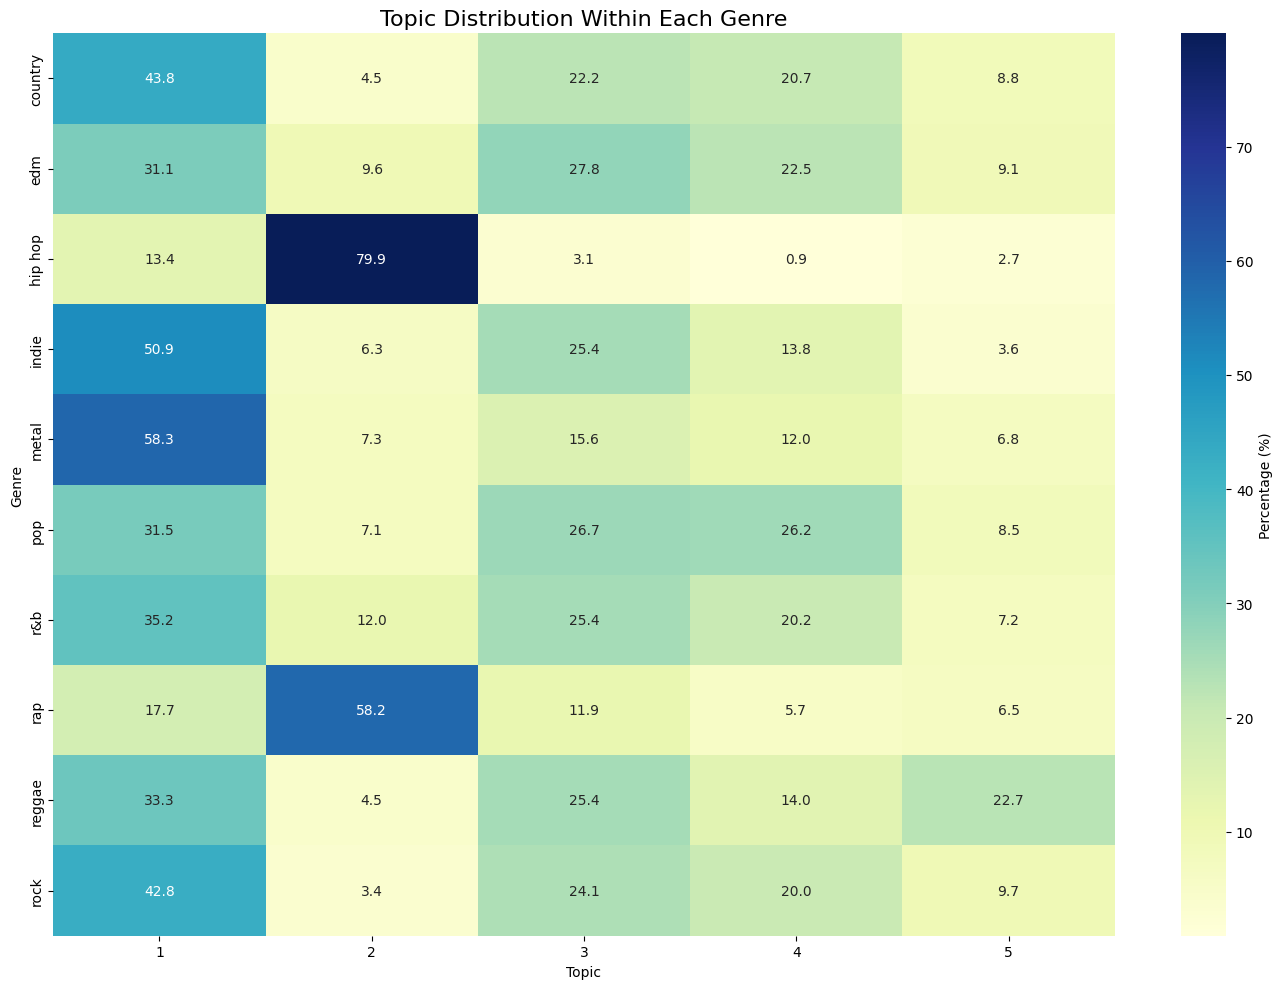

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

assert 'topic' in df.columns, "The dataframe must have a 'topic' column."
assert 'genre' in df.columns, "The dataframe must have a 'genre' column."

genre_topic_counts = df.groupby(['genre', 'topic']).size().reset_index(name='count')

genre_totals = df['genre'].value_counts().reset_index()
genre_totals.columns = ['genre', 'total_songs']

genre_topic_counts = genre_topic_counts.merge(genre_totals, on='genre')

genre_topic_counts['percentage'] = (genre_topic_counts['count'] / genre_topic_counts['total_songs']) * 100

genre_topic_matrix = genre_topic_counts.pivot(index='genre', columns='topic', values='percentage').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(genre_topic_matrix, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage (%)'})
plt.title("Topic Distribution Within Each Genre", fontsize=16)
plt.xlabel("Topic")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

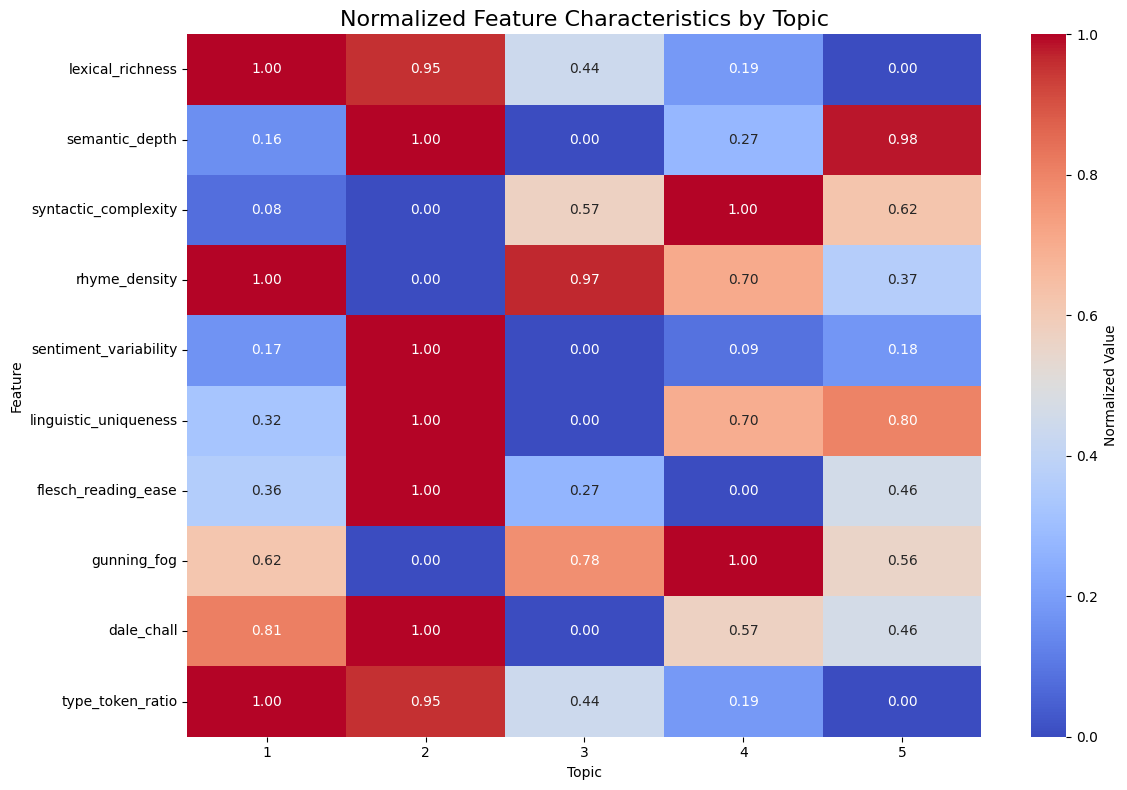

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

lyrical_features = [
    'lexical_richness', 'semantic_depth', 'syntactic_complexity',
    'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
    'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio'
]

assert 'topic' in df.columns, "The dataframe must have a 'topic' column."

topic_features = df.groupby('topic')[lyrical_features].mean()

normalized_topic_features = (topic_features - topic_features.min()) / (topic_features.max() - topic_features.min())

plt.figure(figsize=(12, 8))
sns.heatmap(normalized_topic_features.T, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Normalized Value'})
plt.title("Normalized Feature Characteristics by Topic", fontsize=16)
plt.xlabel("Topic")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


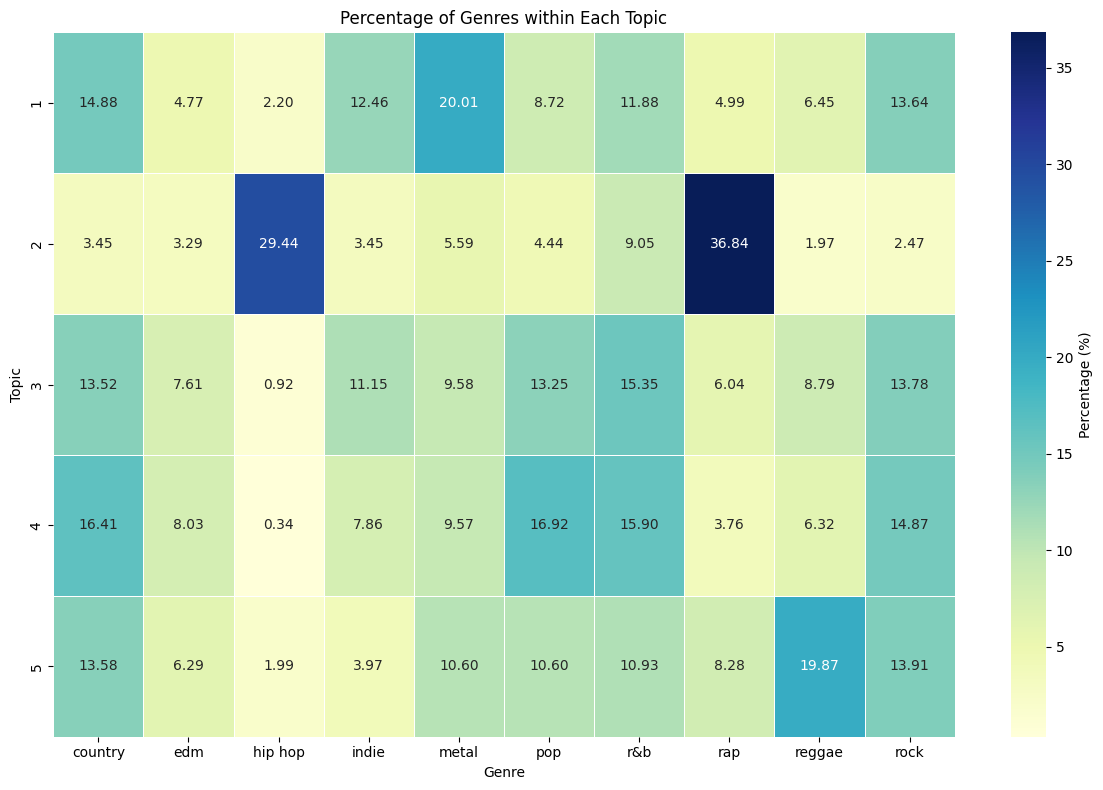

In [161]:
topic_genre_percentage = (topic_genre_crosstab.div(topic_genre_crosstab.sum(axis=1), axis=0) * 100).round(2)

plt.figure(figsize=(12, 8))
sns.heatmap(
    topic_genre_percentage, 
    annot=True, 
    fmt=".2f",  # Format the numbers with 2 decimal places
    cmap="YlGnBu", 
    linewidths=0.5,
    cbar_kws={"label": "Percentage (%)"}
)

plt.title("Percentage of Genres within Each Topic")
plt.ylabel("Topic")
plt.xlabel("Genre")
plt.tight_layout()

plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'lda_genres_distribution_row_normalized.png'))
plt.show()

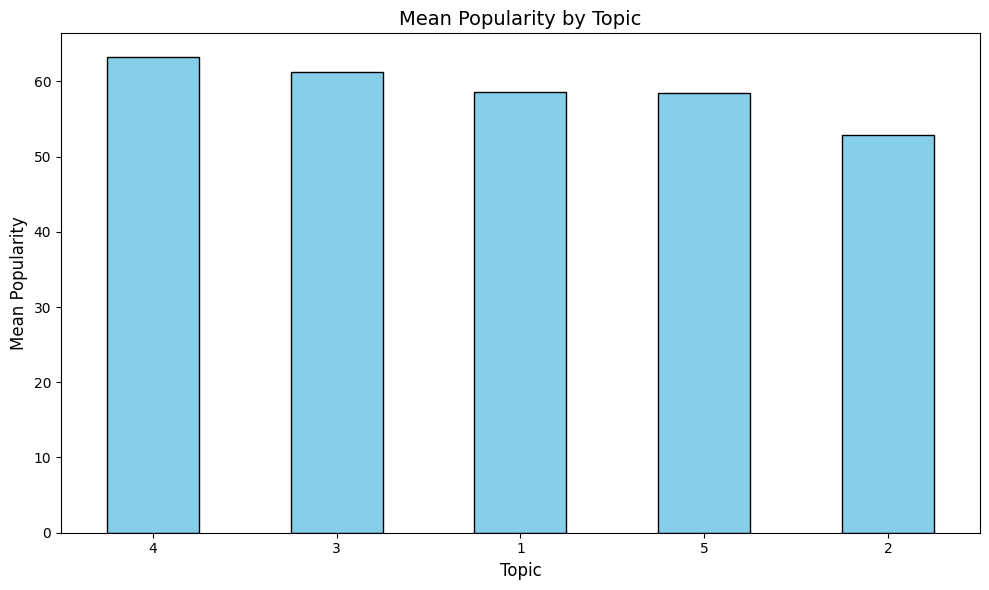

topic
4    63.222222
3    61.216535
1    58.645894
5    58.476821
2    52.873355
Name: popularity, dtype: float64

In [146]:
# Compute mean popularity for each topic
topic_popularity = df.groupby('topic')['popularity'].mean().sort_values(ascending=False)

# Plot the mean popularity for each topic
plt.figure(figsize=(10, 6))
topic_popularity.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Mean Popularity by Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Mean Popularity", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

topic_popularity


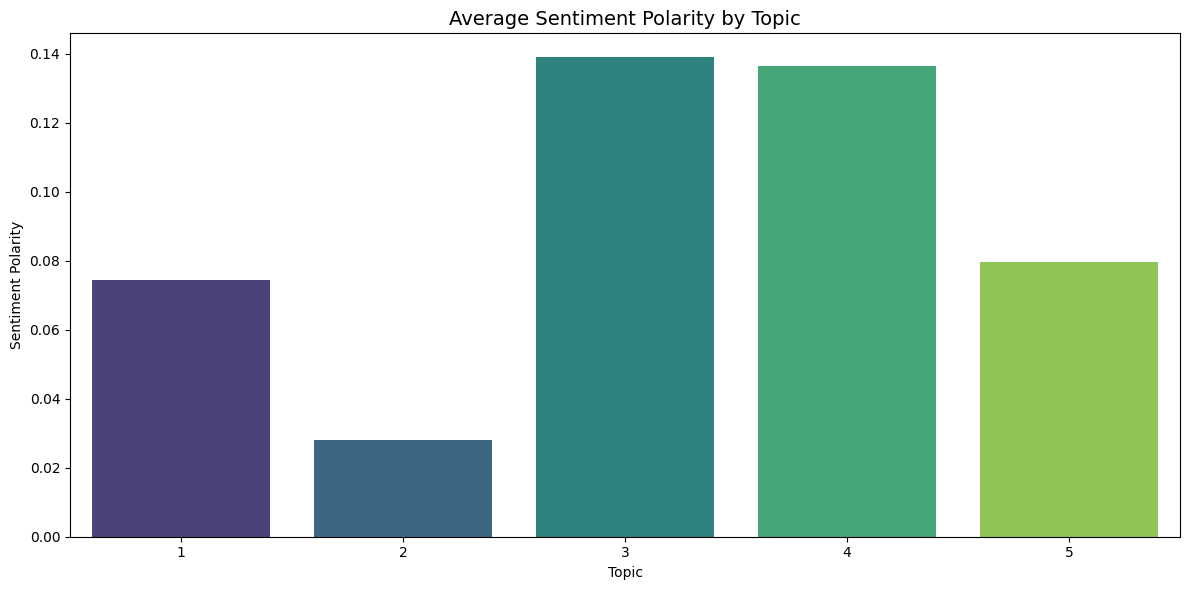

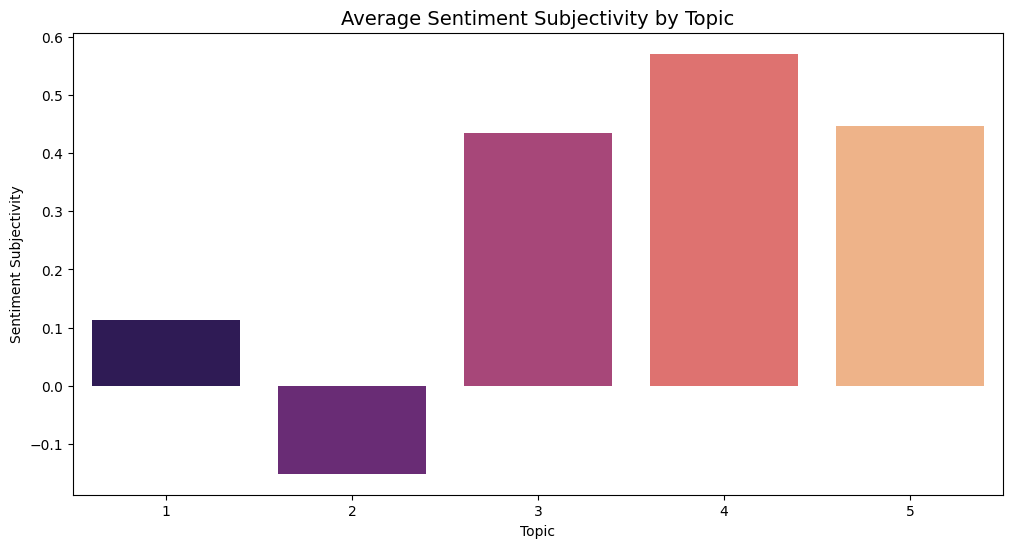

In [169]:
sentiment_data = df.groupby('topic')[['vader_compound', 'sentiment_polarity', 'sentiment_subjectivity']].mean()

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_data.reset_index(), x='topic', y='sentiment_polarity', palette='viridis')
plt.title("Average Sentiment Polarity by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Sentiment Polarity")
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'lda_sentiment.png'))
plt.show()

plt.figure(figsize=(12, 6))
# sns.barplot(data=sentiment_data.reset_index(), x='topic', y='sentiment_subjectivity', palette='magma')
sns.barplot(data=sentiment_data.reset_index(), x='topic', y='vader_compound', palette='magma')
plt.title("Average Sentiment Subjectivity by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Sentiment Subjectivity")
plt.show()


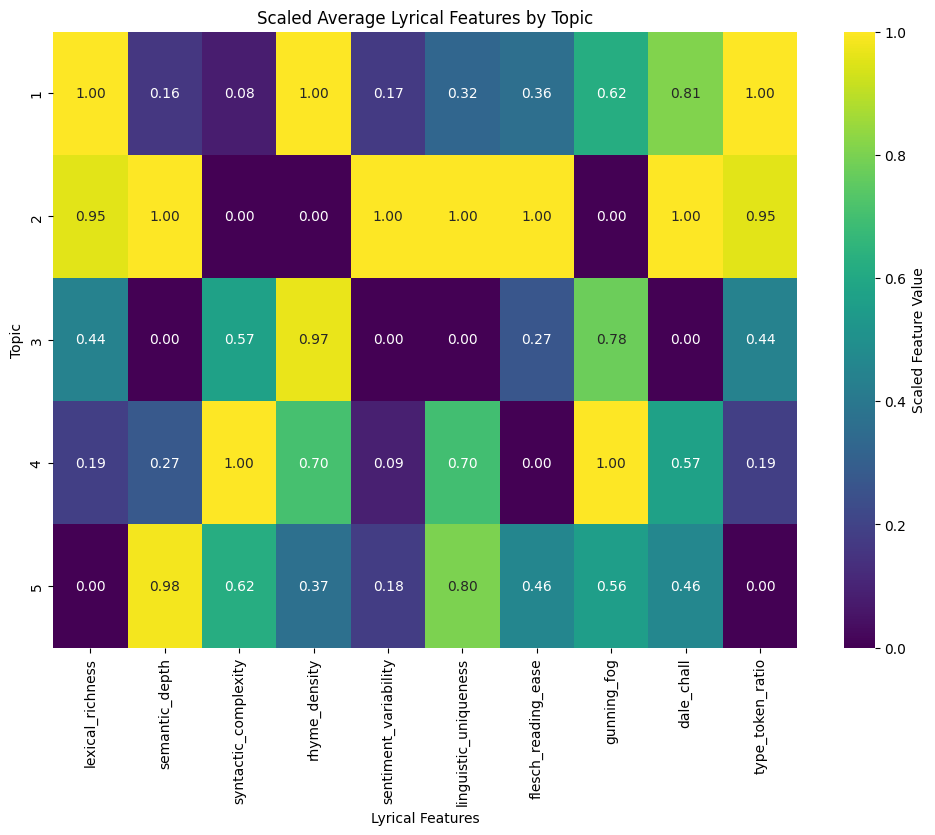

In [148]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average lyrical features per topic
lyrical_features_by_topic = df.groupby('topic')[lyrical_features].mean()

# Min-Max scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lyrical_features_by_topic)
scaled_features_df = pd.DataFrame(scaled_features, columns=lyrical_features, index=lyrical_features_by_topic.index)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    scaled_features_df, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Scaled Feature Value"}
)
plt.title("Scaled Average Lyrical Features by Topic")
plt.xlabel("Lyrical Features")
plt.ylabel("Topic")
plt.show()

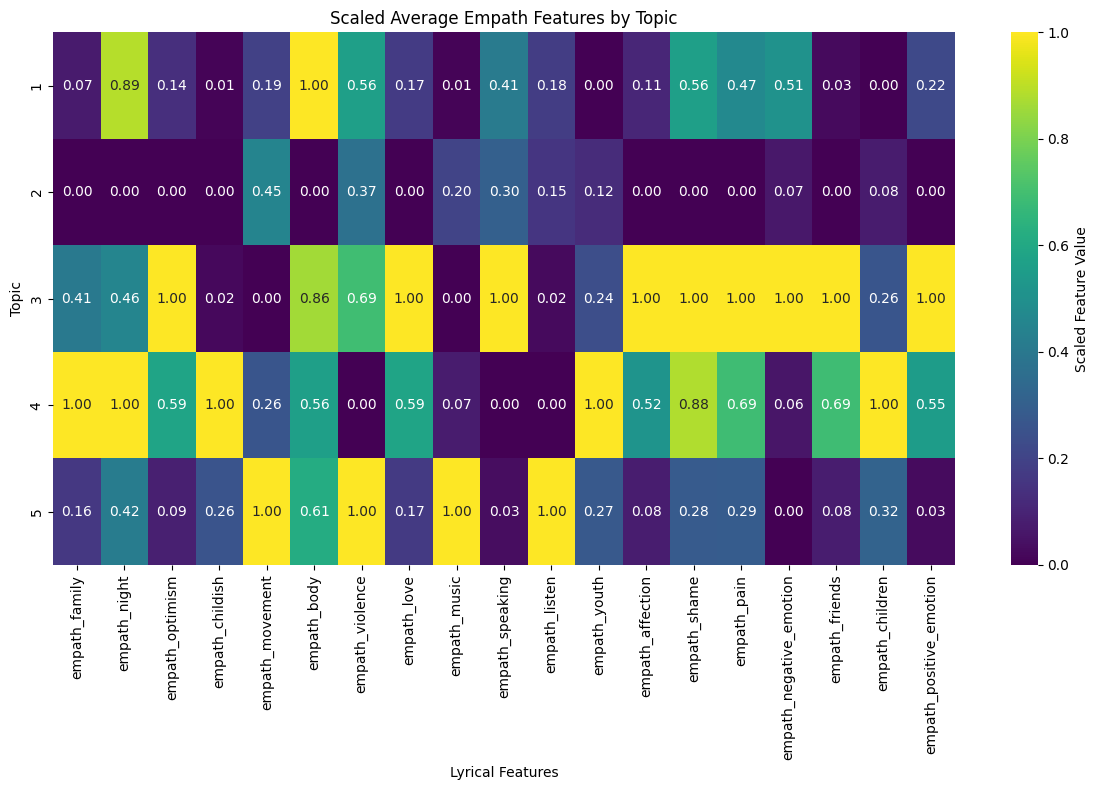

In [165]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average lyrical features per topic
lyrical_features_by_topic = df.groupby('topic')[empath_features].mean()

# Min-Max scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lyrical_features_by_topic)
scaled_features_df = pd.DataFrame(scaled_features, columns=empath_features, index=lyrical_features_by_topic.index)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    scaled_features_df, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Scaled Feature Value"}
)
plt.title("Scaled Average Empath Features by Topic")
plt.xlabel("Lyrical Features")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'lda_empath_features.png'))
plt.show()

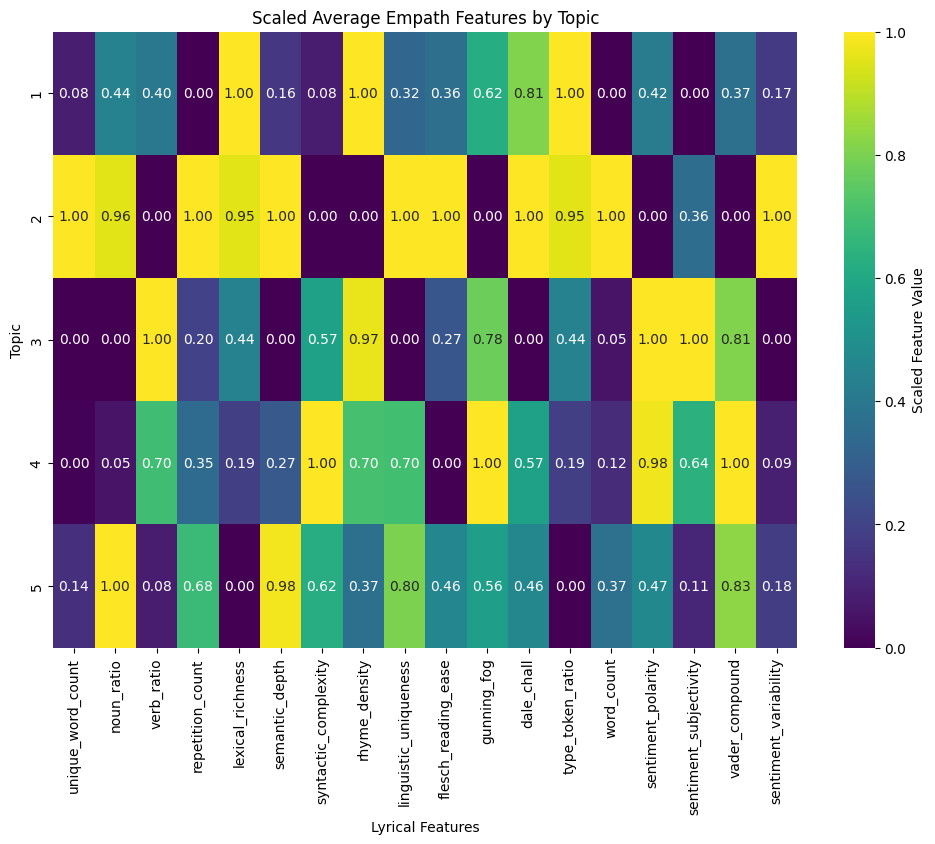

In [150]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

features = [ f for f in lyrics_features if f in df.select_dtypes(include=np.number) ]
# Compute average lyrical features per topic
lyrical_features_by_topic = df.groupby('topic')[features].mean()

# Min-Max scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lyrical_features_by_topic)
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=lyrical_features_by_topic.index)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    scaled_features_df, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Scaled Feature Value"}
)
plt.title("Scaled Average Empath Features by Topic")
plt.xlabel("Lyrical Features")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

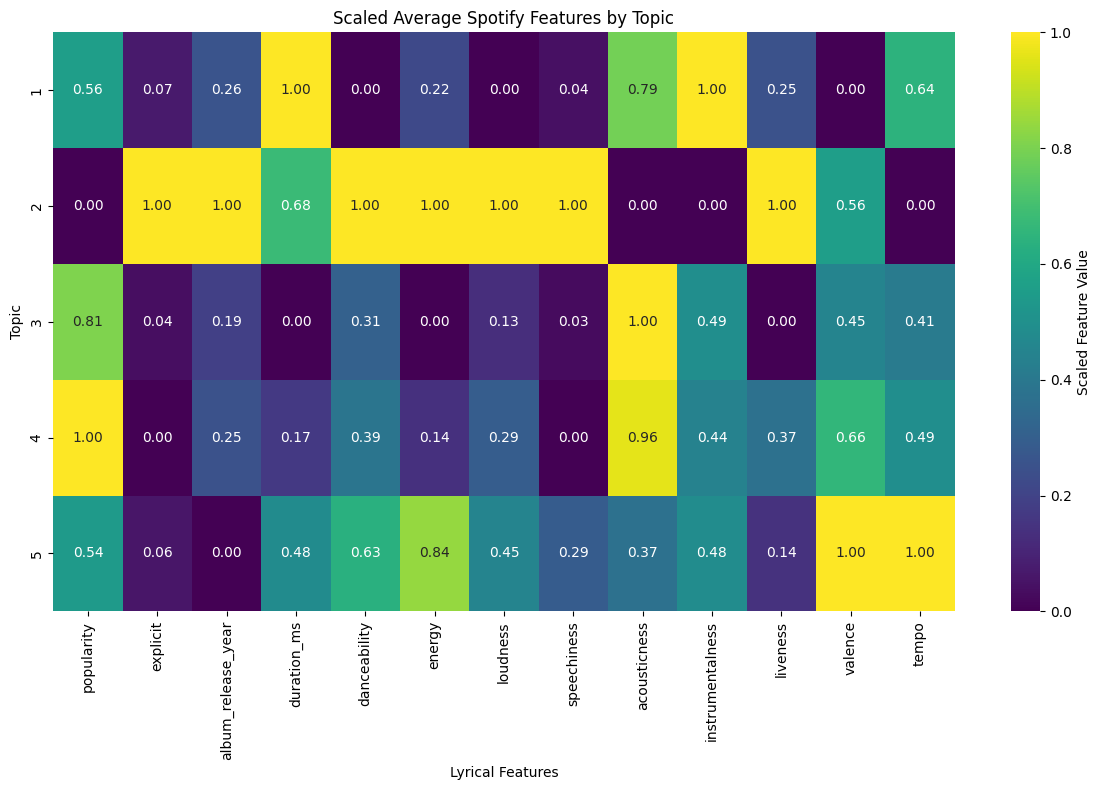

In [172]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df.explicit = df.explicit.astype(int)
features = [ f for f in spotify_features if f in df.select_dtypes(include=np.number) ]
# Compute average lyrical features per topic
lyrical_features_by_topic = df.groupby('topic')[features].mean()

# Min-Max scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lyrical_features_by_topic)
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=lyrical_features_by_topic.index)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    scaled_features_df, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Scaled Feature Value"}
)
plt.title("Scaled Average Spotify Features by Topic")
plt.xlabel("Lyrical Features")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'lda_spotify_features.png'))
plt.show()